In [1]:
from collections.abc import Iterator

import equinox as eqx
import jax
import optax
from jaxtyping import Array, Float, UInt
from tqdm.notebook import trange

from deep_sets_jax.dataset import Dataset
from deep_sets_jax.model import DeepSets, loss

In [2]:
key = jax.random.PRNGKey(1234)
key_model, key_train, key_test = jax.random.split(key, 3)

model = DeepSets(key=key_model)
optim = optax.adam(learning_rate=1e-3)

dataset = Dataset.download_archive()
train_samples = dataset.sample_train(key=key_train)
test_samples = dataset.sample_test(key=key_test)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [3]:
def train(
    model: DeepSets,
    train_samples: Iterator[tuple[Float[Array, "num_images 26 26"], UInt[Array, " "]]],
    test_samples: Iterator[tuple[Float[Array, "num_images 26 26"], UInt[Array, " "]]],
    optim: optax.GradientTransformation,
    steps: int = 10_000,
    print_every: int = 1_000,
    num_test_samples: int = 100,
) -> DeepSets:
    """
    Train a Deep Sets model on a given train set.

    Args:
        model: The DeepSet model to train.
        train_samples: A never-ending generator of train samples.
        test_samples: A never-ending generator of test samples.
        optim: The gradient-based optimizer.
        steps: The number of steps to perform.
        print_every: When to evaluate and print the loss
            on the test set.
        num_test_samples: The number of test samples on which
            the loss is averaged.

    Return:
        The trained model.
    """
    opt_state = optim.init(eqx.filter(model, eqx.is_array))

    @eqx.filter_jit
    def make_step(
        model: DeepSets,
        opt_state: optax.OptState,
        x: Float[Array, "num_images 1 28 28"],
        y: UInt[Array, " "],
    ) -> tuple[DeepSets, optax.OptState, float]:
        """
        Perform one (gradient) step using the gradient of the loss function, and the current optimization state.

        Args:
            model: The Deep Sets model.
            opt_state: The current optimization state.
            x: The input image(s).
            y: The desired output.
        """
        loss_value, grads = eqx.filter_value_and_grad(loss)(model, x, y)
        updates, opt_state = optim.update(grads, opt_state, model)
        model = eqx.apply_updates(model, updates)
        return model, opt_state, loss_value

    with trange(steps, desc="", unit=" steps", leave=False) as bar:
        for step, (x_train, y_train) in zip(bar, train_samples, strict=False):
            model, opt_state, train_loss = make_step(model, opt_state, x_train, y_train)
            if (step % print_every) == 0 or (step == steps - 1):
                test_loss = 0
                for _, (x_test, y_test) in zip(
                    range(num_test_samples), test_samples, strict=False
                ):
                    test_loss += loss(model, x_test, y_test)
                test_loss /= num_test_samples

                bar.set_description(
                    f"train_loss = {float(train_loss):.1f}, test_loss = {float(test_loss):.1f}"
                )

    return model

In [4]:
model = train(model, train_samples, test_samples, optim)

  0%|          | 0/10000 [00:00<?, ? steps/s]

Array(14.083916, dtype=float32)

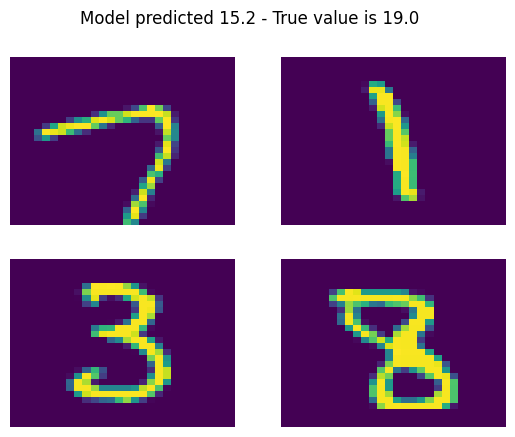

In [5]:
x_test, y_test = next(test_samples)  # Each time this cell is run, a new sample is used.

loss(model, x_test, y_test, plot=True)